In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, LATEX_OUT

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
plt_config = {
    'figure.figsize': (10, 3),
    'figure.dpi': 144,
    'figure.facecolor': 'white',
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'family' : 'normal',
    'weight' : 'bold',
    'size'   : 10,
}

In [3]:
%matplotlib inline

from gEconpy.classes.model import gEconModel

import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.filtering_sampling import solve_updated_mod

import numpy as np
import pandas as pd

import os
from itertools import chain

from config import plt_config
plt.rcParams.update(plt_config)

globals 

In [4]:
plot_vars = ['y', 'n', 's', 'c', 'I', 'w', 'r', 'pi']

load model

In [5]:
from config import mod4_params, mod4_priors, mod5_params, mod5_priors, mod6_params, mod6_priors
mods = {
    'mod4_rbc_vanilla': {'params': mod4_params,
                         'priors': mod4_priors,
                         'is_lin': False,
                         'name': 'RBC'},
    'mod5_nk_vanilla_lin2': {'params': mod5_params,
                            'priors': mod5_priors,
                            'is_lin': True,
                             'name': 'NK'},
    'mod6_nk_energy_lin2': {'params': mod6_params,
                           'is_lin': True,
                           'priors': mod6_priors,
                           'name': 'NK Petrol'}
}

# load model
for key in mods.keys():
    # load
    mods[key]['mod'] = gEconModel(os.path.join(MODEL_DIR, f'{key}.gcn'), verbose=False)
    
    # solve
    _, mods[key]['mod'] = solve_updated_mod(mods[key]['mod'], verbose=True, model_is_linear=mods[key]['is_lin'])
    assert _ == True
    
    # get shocks
    mods[key]['shocks'] = [item.base_name for item in mods[key]['mod'].shocks]

Steady state found! Sum of squared residuals is 6.695074537413149e-23
Solution found, sum of squared residuals:  5.257037621106411e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.
Steady state found! Sum of squared residuals is 6.1286653075070395e-27
Solution found, sum of squared residuals:  2.563134175042647e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.
Steady state found! Sum of squared residuals is 0.0
Solution found, sum of squared residuals:  1.0761026461439942e-33
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-K

covariance matrix

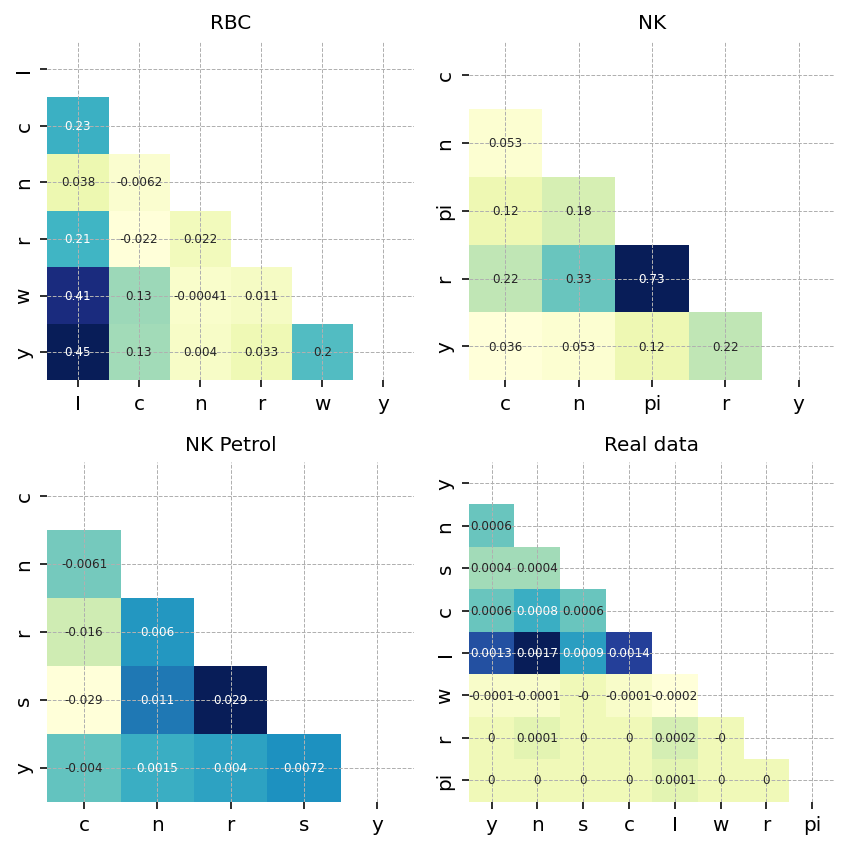

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

for key, ax1, ax2 in [('mod4_rbc_vanilla', 0,0), ('mod5_nk_vanilla_lin2',0,1), ('mod6_nk_energy_lin2', 1,0)]:
    ax_ = (ax1, ax2)

    cov = mods[key]['mod'].compute_stationary_covariance_matrix()
    mods[key]['cov'] = cov
    cov = cov.loc[[item for item in cov.index if item in plot_vars], [item for item in cov.columns if item in plot_vars]]
    
    mask = np.zeros_like(cov)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(cov, cmap='YlGnBu', ax=ax[ax_], mask=mask, annot=True, annot_kws={'size':6}, cbar=False)
    ax[ax_].set_title(mods[key]['name'], size=10)
    
# data
cov = pd.read_csv(os.path.join(LATEX_OUT, 'data_cov.csv')).rename(columns={'Unnamed: 0': ''})
cov.set_index('', inplace=True)
cov = cov.round(4)
cov = cov.loc[plot_vars, plot_vars]

mask = np.zeros_like(cov)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cov, cmap='YlGnBu', ax=ax[1, 1], mask=mask, annot=True, annot_kws={'size':6}, cbar=False)
ax[1,1].set_title('Real data', size=10)

fig.tight_layout()

fig.savefig(os.path.join(LATEX_OUT, 'cov_matrix.png'))

### IRF

In [ ]:
shock_size = -.1
sim_length = 120

In [ ]:
for key in mods.keys():
    # get irfs
    mods[key]['irf'] = mods[key]['mod'].impulse_response_function(simulation_length=sim_length, shock_size=shock_size)
    
    # plot irf per shock
    dfs = [mods[key]['irf'].unstack().loc[:, item].unstack() for item in mods[key]['shocks']]
    plot_dfs(dfs, sns.lineplot, legend=mods[key]['shocks'], fig_title=f'{mods[key]["name"]}')